<a href="https://colab.research.google.com/github/mathena828/GAN_Fashion-MNIST/blob/main/CGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [176]:
# Import libraries.
import time
import tensorflow as tf
from matplotlib import pyplot
from keras.optimizers import Adam
from numpy.random import randn, randint
from keras.models import Model, load_model
from numpy import expand_dims, ones, zeros, asarray
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Dropout, Embedding, Concatenate, LeakyReLU

In [177]:
# Download the Fashion MNIST dataset.
(train_images, train_labels), (test_images, test_labels) =  tf.keras.datasets.fashion_mnist.load_data()

In [178]:
# Pre-process the 60,000 training set images.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # Convert pixels to floating point values. 
train_images = (train_images - 127.5) / 127.5 # Normalize the pixel values to be in the range of [-1,1].
train_dataset = [train_images, train_labels]

In [179]:
# Perform hyperparameter optimization.
BATCH = 256
EPOCHS = 5 
LATENT_DIM = 100

In [180]:
# Define the generator.
def build_generator(latent_dim, classes=10):
  # Each of the 10 classes for the Fashion MNIST dataset will map to a different 50-element vector representation.
  labels = Input(shape=(1,))
  input_labels = Embedding(classes, 50)(labels)
  # The embedding is passed through a fully connected layer with a linear activation.
  nodes = 7 * 7
  input_labels = Dense(nodes)(input_labels)
  input_labels = Reshape((7, 7, 1))(input_labels) # Reshape into (None, 7, 7, 1).
  # Initialize the image generator input.
  input_latent = Input(shape=(latent_dim,))
  nodes = 128 * 7 * 7
  layer = Dense(nodes)(input_latent)
  layer = LeakyReLU(alpha=0.2)(layer)
  layer = Reshape((7, 7, 128))(layer)
  merge = Concatenate()([layer, input_labels]) # Concatenate the input labels and with the input images.
  # Upsample with Conv2D and LeakyReLU.
  layer = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  layer = LeakyReLU(alpha=0.2)(layer)
  layer = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(layer)
  layer = LeakyReLU(alpha=0.2)(layer)
  output_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(layer)
  model = Model([input_latent, labels], output_layer) # Define the model.
  return model

In [181]:
# Build the generator.
generator = build_generator(LATENT_DIM)

In [182]:
# Define the discriminator.
def build_discriminator(input_shape=(28,28,1), classes=10):
  # Each of the 10 classes for the Fashion MNIST dataset will map to a different 50-element vector representation that will be learned by the discriminator model.
	labels = Input(shape=(1,))
	input_labels = Embedding(classes, 50)(labels)
  # The embedding is scaled up to image dimensions with linear activation.
	nodes = input_shape[0] * input_shape[1]
	input_labels = Dense(nodes)(input_labels)
	input_labels = Reshape((input_shape[0], input_shape[1], 1))(input_labels) # Reshape into (None, 28, 28, 1).
	input_images = Input(shape=input_shape)
	merge = Concatenate()([input_images, input_labels]) # Concatenate the input labels and with the input images.
	# Downsample with Conv2D and LeakyReLU.
	layer = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	layer = LeakyReLU(alpha=0.2)(layer)
	layer = Conv2D(128, (3,3), strides=(2,2), padding='same')(layer)
	layer = LeakyReLU(alpha=0.2)(layer)
	# Flatten feature maps and pass it to the dense layer to complete the classifier.
	layer = Flatten()(layer)
	layer = Dropout(0.4)(layer)
	output_layer = Dense(1, activation='sigmoid')(layer)
	# Define and compile the model with an Adam optimizer.
	model = Model([input_images, labels], output_layer)
	adam = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
	return model

In [118]:
# Build the discriminator.
discriminator = build_discriminator()

In [135]:
# Define the CGAN.
@tf.function # Compile the function into a callable TensorFlow graph.
def build_cgan(generator, discriminator):
	discriminator.trainable = False # Set the weights in the discriminator to be not trainable.
	# Get the noise, label inputs, and image outputs from generator.
	noise, label = generator.input
	output = generator.output
	# Connect the image output and label input from the generator as inputs to the discriminator.
	cgan_output = discriminator([output, label])
	model = Model([noise, label], cgan_output)
	# Compile the model with an Adam optimizer.
	adam = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=adam)
	return model

In [94]:
# Build the CGAN.
cgan = build_cgan(generator, discriminator)

In [87]:
# Select real samples from the dataset.
def get_real_samples(train_dataset, samples):
  images, labels = train_dataset
  index = randint(0, images.shape[0], samples)
  x, labels = images[index], labels[index]
  y = ones((samples, 1)) # Generate class labels of value 1 to indicate the images are real.
  return [x, labels], y

In [68]:
# Create an array of randomly selected integer class labels for randomly selected points in the latent space.
def get_latent_points(latent_dim, samples, classes=10):
	x_input = randn(latent_dim * samples)
	z_input = x_input.reshape(samples, latent_dim)
	labels = randint(0, classes, samples)
	return [z_input, labels]

In [88]:
# Generate fake images with class labels using the generator.
def get_fake_samples(generator, latent_dim, samples):
	z_input, labels_input = get_latent_points(latent_dim, samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((samples, 1))
	return [images, labels_input], y

In [142]:
# Create and save a plot of generated images.
def save_plot(examples, n, epoch):
  for i in range(n * n):
    pyplot.subplot(n, n, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(examples[i, :, :, 0], cmap='gray')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  pyplot.show()

In [169]:
# Iterate over the number of epochs and train the CGAN on the dataset in batches.
def train(generator, discriminator, cgan, train_dataset, latent_dim, epochs, batch):
  batch_per_epoch = int(train_dataset[0].shape[0] / batch)
  half_batch = int(batch / 2)
  for epoch in range(epochs):
    start = time.time() # Get the starting time of each epoch.
    for batch in range(batch_per_epoch):
      # Update discriminator model weights using randomly selected real images.
      [images_real, labels_real], y_real = get_real_samples(train_dataset, half_batch)
      d_loss1, _ = discriminator.train_on_batch([images_real, labels_real], y_real)
      # Update discriminator model weights using fake images.
      [images_fake, labels_fake], y_fake = get_fake_samples(generator, latent_dim, half_batch)
      d_loss2, _ = discriminator.train_on_batch([images_fake, labels_fake], y_fake)
      # Update the generator based on the discriminator's error.
      [z_input, labels_input] = get_latent_points(latent_dim, batch)
      y_cgan = ones((batch, 1)) 
      cgan_loss = cgan.train_on_batch([z_input, labels_input], y_cgan)
      # print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (epoch+1, batch+1, batch_per_epoch, d_loss1, d_loss2, cgan_loss))
    print('Time for epoch {} is {} seconds.'.format(epoch + 1, time.time()-start)) # Record how long it took for each epoch to run.
generator.save('cgan_generator.h5')

In [172]:
train(generator, discriminator, cgan, train_dataset, LATENT_DIM, EPOCHS, BATCH)

Time for epoch 1 is 1284.7772479057312 seconds.
Time for epoch 2 is 1276.6784536838531 seconds.
Time for epoch 3 is 1255.888658285141 seconds.
Time for epoch 4 is 1258.2964925765991 seconds.
Time for epoch 5 is 1261.4287836551666 seconds.


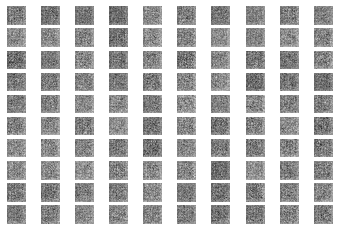

In [192]:
# Create and save generated images.
def save_plot(examples, n):
	for i in range(n * n):
		pyplot.subplot(n, n, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()
 
# Load the trained model.
model = load_model('cgan_generator.h5', compile=False)
latent_points, labels = get_latent_points(100, 100)
labels = asarray([x for _ in range(10) for x in range(10)])
final  = model.predict([latent_points, labels])
final = (final + 1) / 2.0 # Scale from [-1,1] to [0,1]
save_plot(final, 10)